To study sampling and reconstruction of speech signals at different sampling rates, evaluate reconstruction using zero-order hold and linear interpolation, and implement the source-filter model to analyze the effect of filtering, sampling, and reconstruction on speech quality.


### 1. Implement sampling and quantization techniques for the given speech signals.

(a) Plot the time domain representation of the original speech signal.


/tmp/ipython-input-1367066208.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, signal = wav.read("harvard.wav")


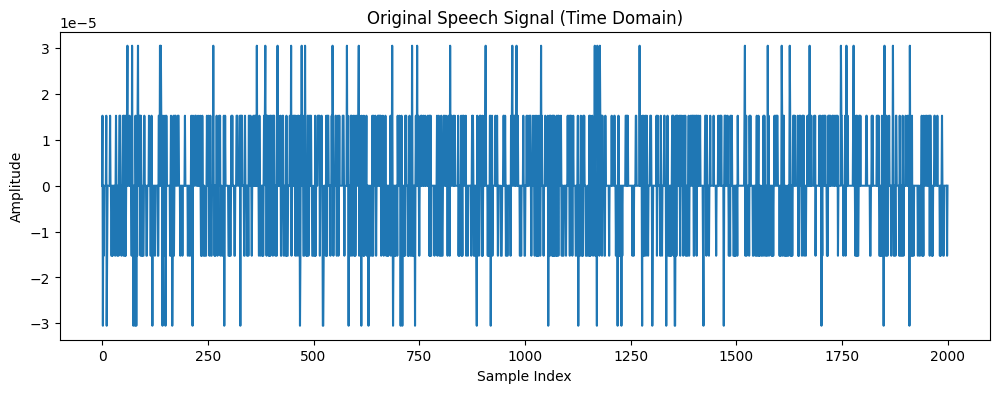

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import resample

# 1(a) Load and normalize original speech signal
sr, signal = wav.read("harvard.wav")
if signal.ndim > 1:  # if stereo, take mean
    signal = np.mean(signal, axis=1)
signal = signal.astype(np.float32) / np.max(np.abs(signal))

# Plot original signal
plt.figure(figsize=(12,4))
plt.plot(signal[:2000])
plt.title("Original Speech Signal (Time Domain)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

(b) Sample the speech signal at different sampling rates (e.g., 8kHz, 16kHz, and 44.1kHz).


In [15]:
sampling_rates = [8000, 16000, 44100]
sampled_signals = {}
for fs in sampling_rates:
    num_samples = int(len(signal) * fs / sr)
    sampled_signals[fs] = resample(signal, num_samples)

(c) Plot sampled speech signal for each of these sampling rates.


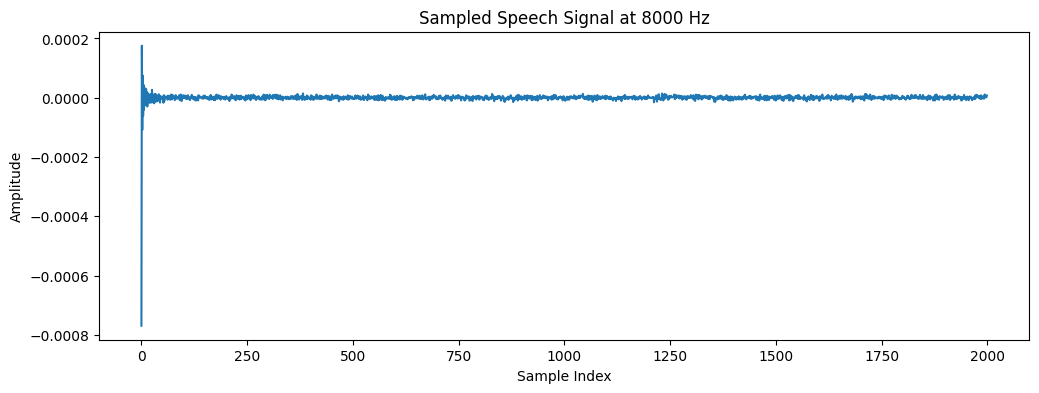

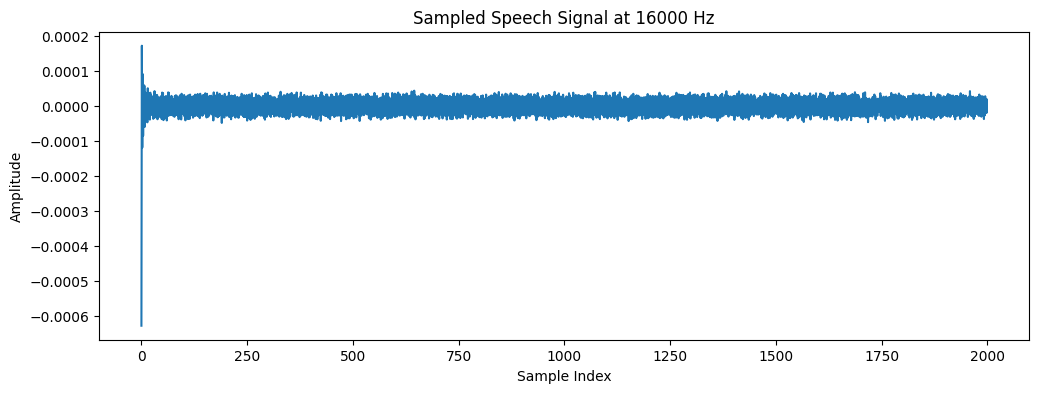

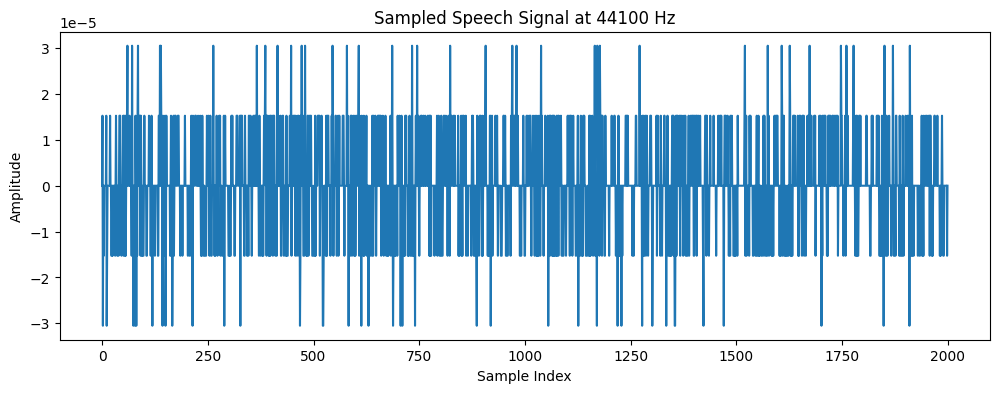

In [16]:
for fs in sampling_rates:
    plt.figure(figsize=(12,4))
    plt.plot(sampled_signals[fs][:2000])
    plt.title(f"Sampled Speech Signal at {fs} Hz")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

(d) Using the sampled signals from above, reconstruct the signal using:

(i) Zero-order hold (nearest-neighbor interpolation)

(ii) Linear interpolation.

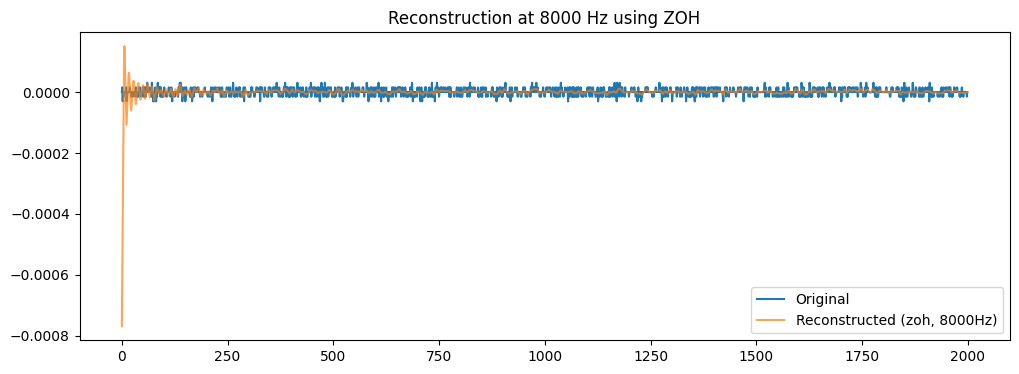

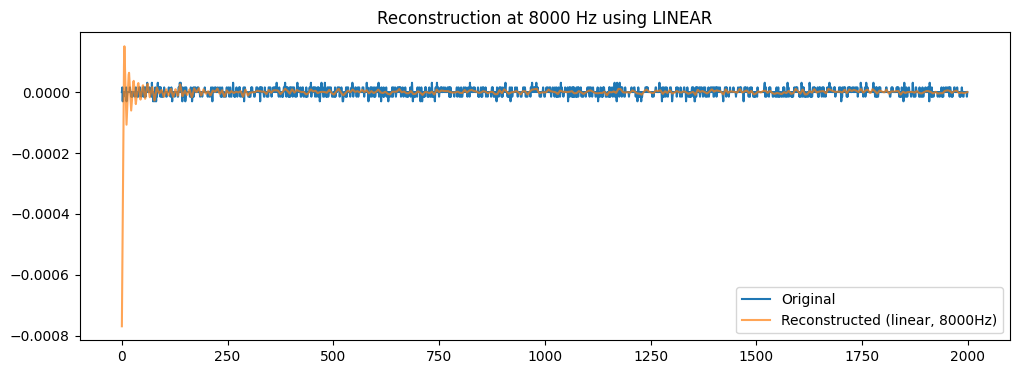

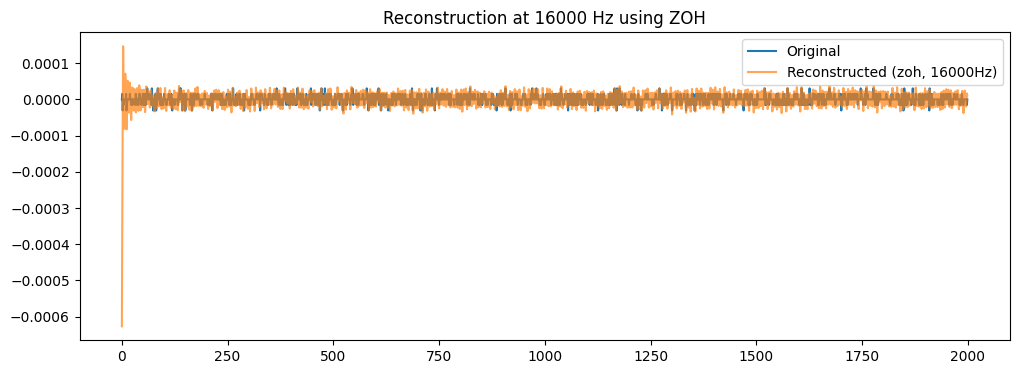

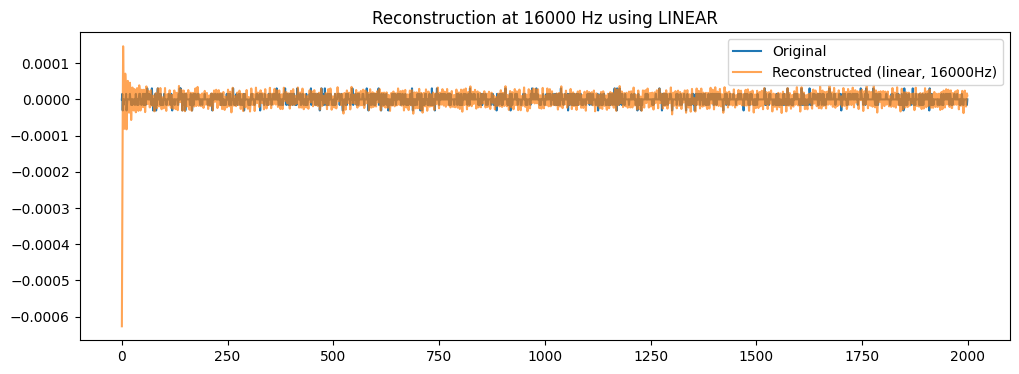

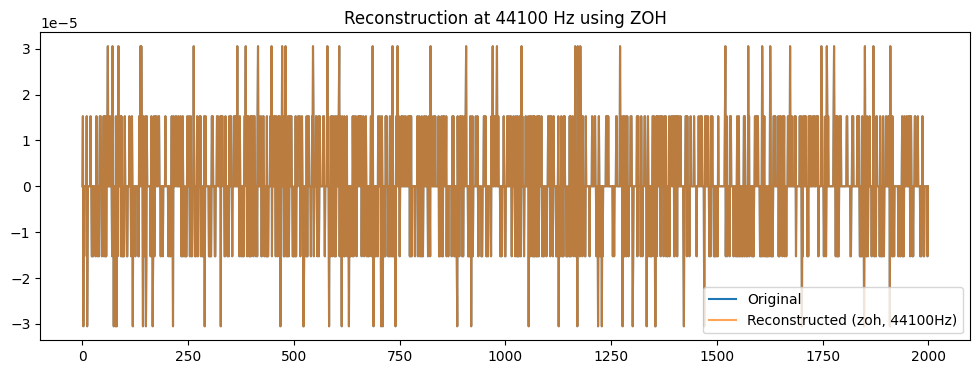

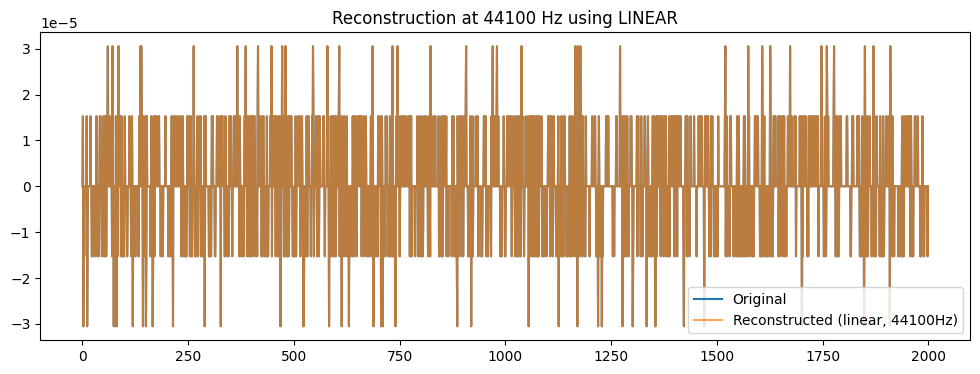

In [17]:
def reconstruct(signal, fs, method="zoh"):
    t_original = np.linspace(0, len(signal)/sr, len(signal))
    t_new = np.linspace(0, len(signal)/sr, int(len(signal)*fs/sr))
    sampled = resample(signal, len(t_new))

    if method == "zoh":  # Zero-order hold
        reconstructed = np.interp(t_original, t_new, sampled, left=0, right=0)
    elif method == "linear":  # Linear interpolation
        reconstructed = np.interp(t_original, t_new, sampled)
    return reconstructed

#Reconstruct and plot
mse_results = {}
for fs in sampling_rates:
    for method in ["zoh", "linear"]:
        rec = reconstruct(signal, fs, method)
        mse = np.mean((signal - rec)**2)
        mse_results[(fs, method)] = mse

        plt.figure(figsize=(12,4))
        plt.plot(signal[:2000], label="Original")
        plt.plot(rec[:2000], label=f"Reconstructed ({method}, {fs}Hz)", alpha=0.7)
        plt.legend()
        plt.title(f"Reconstruction at {fs} Hz using {method.upper()}")
        plt.show()


(e) Calculate the Mean Squared Error (MSE) between the original and the reconstructed signals for both methods.

In [18]:
print("Mean Squared Error (MSE):")
for k,v in mse_results.items():
    print(f"Sampling Rate: {k[0]} Hz, Method: {k[1]} -> MSE: {v:.6f}")

Mean Squared Error (MSE):
Sampling Rate: 8000 Hz, Method: zoh -> MSE: 0.000157
Sampling Rate: 8000 Hz, Method: linear -> MSE: 0.000157
Sampling Rate: 16000 Hz, Method: zoh -> MSE: 0.000047
Sampling Rate: 16000 Hz, Method: linear -> MSE: 0.000047
Sampling Rate: 44100 Hz, Method: zoh -> MSE: 0.000000
Sampling Rate: 44100 Hz, Method: linear -> MSE: 0.000000


# Conclusion:
* Lower sampling rates (e.g., 8 kHz) lose high-frequency details, making speech sound muffled and less accurate.

* Higher rates (44.1 kHz) preserve more details and yield lower reconstruction error.

* At lower rates (8 kHz, 16 kHz), Linear interpolation performs slightly better (smoother curve, less step-like distortion).

* MSE decreases as sampling rate increases, indicating better approximation of the original speech.

**********************************************************************

### 2. Implement the source-filter model for a given speech signal and analyze the impact of sampling and reconstruction on the quality of the speech signal.


In [20]:
from scipy.signal import lfilter

# 2(a) Generate synthetic speech (1 second)
duration = 1.0
t = np.linspace(0, duration, int(sr*duration), endpoint=False)

# Voiced source: glottal pulse train
f0 = 100  # Hz
source_voiced = (np.sin(2*np.pi*f0*t) > 0).astype(float)

# Unvoiced source: white noise
source_unvoiced = np.random.randn(len(t))

# Vocal tract filter (formants 500, 1500, 2500 Hz)
formants = [500, 1500, 2500]
B = [1.0]
A = [1.0]
for f in formants:
    r = 0.95
    theta = 2*np.pi*f/sr
    A = np.convolve(A, [1, -2*r*np.cos(theta), r**2])

# Filter the source signals
speech_voiced = lfilter(B, A, source_voiced)
speech_unvoiced = lfilter(B, A, source_unvoiced)

(b) Plot the generated speech signal and analyze the effect of the filter on the original source.


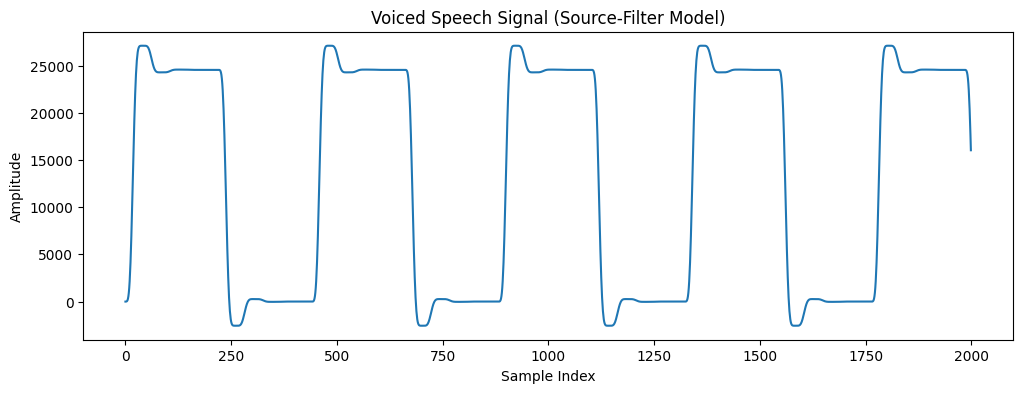

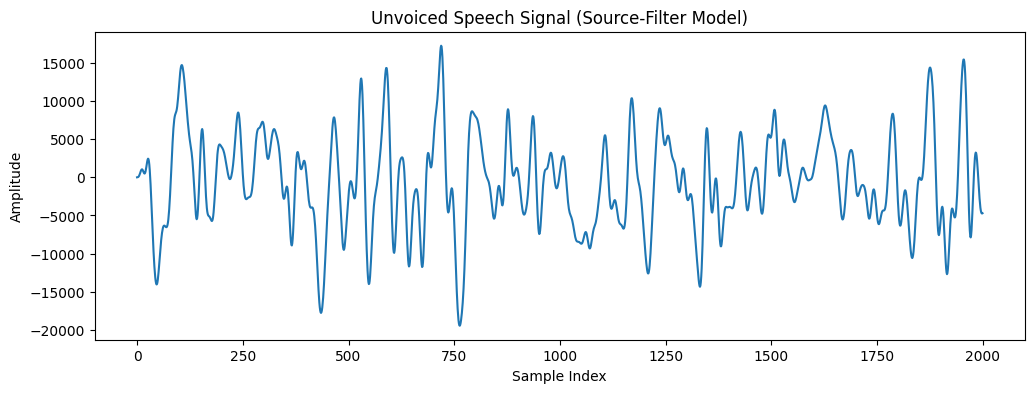

In [21]:
plt.figure(figsize=(12,4))
plt.plot(speech_voiced[:2000])
plt.title("Voiced Speech Signal (Source-Filter Model)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(speech_unvoiced[:2000])
plt.title("Unvoiced Speech Signal (Source-Filter Model)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

(c) Sample the speech signal generated above at different sampling rates (e.g., 8 kHz, 16 kHz, 44.1 kHz).

In [22]:
sampled_speech = {}
for fs in sampling_rates:
    num_samples = int(len(speech_voiced) * fs / sr)
    sampled_speech[fs] = resample(speech_voiced, num_samples)

(d) Reconstruct the signal using a suitable interpolation method (e.g., zero-order hold, linear interpolation).

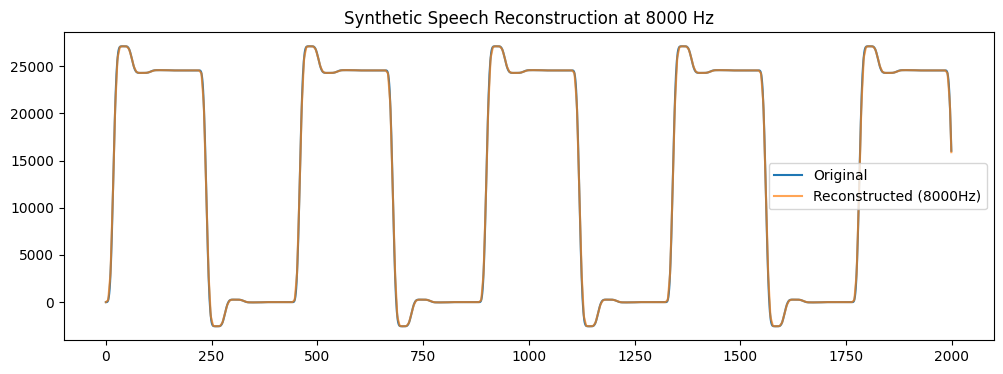

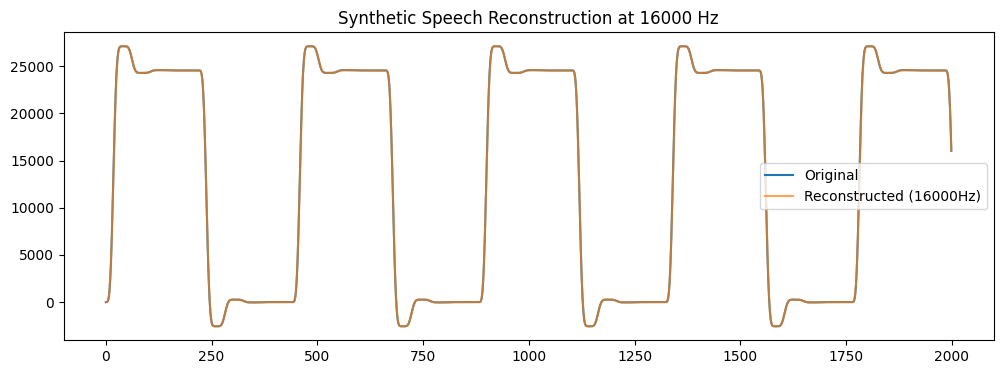

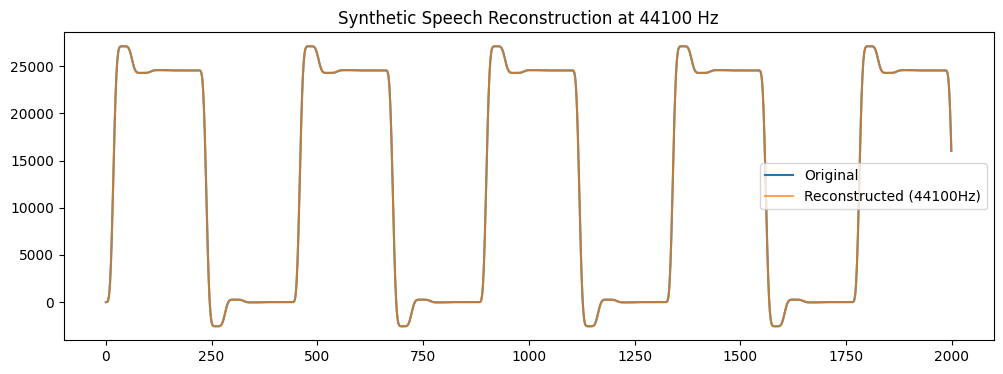

In [23]:
mse_speech = {}
for fs in sampling_rates:
    rec = reconstruct(speech_voiced, fs, method="linear")
    mse = np.mean((speech_voiced - rec)**2)
    mse_speech[fs] = mse

    plt.figure(figsize=(12,4))
    plt.plot(speech_voiced[:2000], label="Original")
    plt.plot(rec[:2000], label=f"Reconstructed ({fs}Hz)", alpha=0.7)
    plt.legend()
    plt.title(f"Synthetic Speech Reconstruction at {fs} Hz")
    plt.show()

(e) Compute the Mean Squared Error (MSE) between the original and reconstructed speech signals.

In [24]:
print("MSE for Synthetic Speech Reconstruction:")
for fs, mse in mse_speech.items():
    print(f"Sampling Rate: {fs} Hz -> MSE: {mse:.6f}")

MSE for Synthetic Speech Reconstruction:
Sampling Rate: 8000 Hz -> MSE: 1081285.100893
Sampling Rate: 16000 Hz -> MSE: 168555.986217
Sampling Rate: 44100 Hz -> MSE: 0.000000


# Conclusion:
*   The source-filter model demonstrates how vocal tract filtering shapes the source waveform into speech-like signals.
*   Higher sampling rates capture more formant details and reduce reconstruction error.
*   Reconstruction at lower rates loses some resonance characteristics, making speech sound less natural.
*   Linear interpolation works well for synthetic signals; MSE decreases with higher sampling rate.









